# Tutorial 3: How simulations define your predictions
The inverse problem has no unique solution as it is ill-posed. In order to solve it we need to constraint the space of possible solutions. While inverse solutions like minimum-norm estimates have an explicit constraint of minimum-energy, the constraints with esinet are implicit and mostly shaped by the simulations.

This tutorial aims the relation between simulation parameters and predictions.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [3]:
info = get_info(sfreq=100)
fwd = create_forward_model(sampling="ico3", info=info)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


# Simulate

## defs

In [4]:
import numpy as np
def prep_data(sim):
    X = np.squeeze(np.stack([eeg.average().data for eeg in sim.eeg_data]))
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.squeeze(np.stack([src.data for src in sim.source_data]))
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)

    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    return X, y

def sparsity(y_true, y_pred):
    return K.mean(K.square(y_pred)) / K.max(K.square(y_pred))
def custom_loss():
    def loss(y_true, y_pred):
        loss1 = tf.keras.losses.CosineSimilarity()(y_true, y_pred)
        loss2 = sparsity(None, y_pred)
        return loss1 + loss2 * 1e-3
    return loss

from esinet.evaluate import auc_metric, eval_auc, eval_nmse, eval_mean_localization_error

def eval(y_true, y_hat):
    n_samples = y_true.shape[0]
    n_time = y_true.shape[1]
    aucs = np.zeros((n_samples, n_time))
    mles = np.zeros((n_samples, n_time))
    nmses = np.zeros((n_samples, n_time))
    for i in range(n_samples):
        for j in range(n_time):
            aucs[i,j] = np.mean(eval_auc(y_true[i,j], y_hat[i,j], pos))
            nmses[i,j] = eval_nmse(y_true[i,j], y_hat[i,j])
            mles[i,j] = eval_mean_localization_error(y_true[i,j], y_hat[i,j], pos)

    return aucs, nmses, mles

def threshold_activation(x):
    return tf.cast(x > 0.5, dtype=tf.float32)

## sim

In [5]:
n_samples = 10000
settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,10), target_snr=99999)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)

Simulating data based on sparse patches.


100%|██████████| 10000/10000 [00:00<00:00, 13831.79it/s]


source data shape:  (1284, 25) (1284, 25)


100%|██████████| 10000/10000 [00:39<00:00, 253.70it/s]


# LSTM

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation, Dropout
from tensorflow.keras.regularizers import l1
from esinet.losses import nmse_loss, nmae_loss

leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 200
n_lstm_units = 32
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2


inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(fc1)

lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM1')(fc1)
mask = TimeDistributed(Dense(n_dipoles, 
            activation="sigmoid"), 
            name='Mask')(lstm1)
multi = multiply([direct_out, mask], name="multiply")
model = tf.keras.Model(inputs=inputs, outputs=multi, name='Contextualizer')


model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")
# model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=[tf.keras.losses.CosineSimilarity()])


model.summary()
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Epoch 1/70
266/266 [==============================] - 4s 15ms/step - loss: -0.6317 - val_loss: -0.5451
Epoch 2/70
266/266 [==============================] - 3s 13ms/step - loss: -0.6344 - val_loss: -0.5475
Epoch 3/70
266/266 [==============================] - 3s 12ms/step - loss: -0.6362 - val_loss: -0.5463
Epoch 4/70
266/266 [==============================] - 4s 15ms/step - loss: -0.6375 - val_loss: -0.5500
Epoch 5/70
266/266 [==============================] - 4s 13ms/step - loss: -0.6377 - val_loss: -0.5489
Epoch 6/70
266/266 [==============================] - 3s 12ms/step - loss: -0.6415 - val_loss: -0.5520
Epoch 7/70
266/266 [==============================] - 3s 12ms/step - loss: -0.6432 - val_loss: -0.5500
Epoch 8/70
266/266 [==============================] - 3s 12ms/step - loss: -0.6440 - val_loss: -0.5513
Epoch 9/70
266/266 [==============================] - 3s 13ms/step - loss: -0.6456 - val_loss: -0.5523
Epoch 10/70
266/266 [==============================] - 3s 12ms/step - los

KeyboardInterrupt: 

# Old LSTM

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 128
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)
lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, name='LSTM1'))(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(lstm1)


model2 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='LSTM_Old')


model2.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")
# model2.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=[tf.keras.losses.CosineSimilarity()])
# model2.compile(loss="mae", optimizer="adam", metrics=[tf.keras.losses.CosineSimilarity()])

model2.summary()
model2.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "LSTM_Old"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 61)]        0         
                                                                 
 FC1 (TimeDistributed)       (None, None, 300)         18600     
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        330240    
 l)                                                              
                                                                 
 FC2 (TimeDistributed)       (None, None, 1284)        329988    
                                                                 
Total params: 678,828
Trainable params: 678,828
Non-trainable params: 0
____________________________________________________

# FC

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 600
n_lstm_units = 30
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(fc1)


model3 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='FC')


model3.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")

model3.summary()
model3.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 61)]        0         
                                                                 
 FC1 (TimeDistributed)       (None, None, 600)         37200     
                                                                 
 FC2 (TimeDistributed)       (None, None, 1284)        771684    
                                                                 
Total params: 808,884
Trainable params: 808,884
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
266/266 [==============================] - 2s 8ms/step - loss: -0.2608 - val_loss: -0.3191
Epoch 2/30
266/266 [==============================] - 2s 6ms/step - loss: -0.3389 - val_loss: -0.3502
Epoch 3/30
266/266 [==============================] - 2s 6ms/step - loss: -0.3595 - val_loss: -0.3633
Epoch 4/30
266/2

# Eval

In [20]:
import numpy as np
from scipy.stats import pearsonr

n_samples = 10
settings = dict(duration_of_trial=0.25, number_of_sources=(1,10), extents=(1,40))
# settings = dict(duration_of_trial=0.25, number_of_sources=5, extents=(1,2))

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X_test, y_test = prep_data(sim_test)

# models = [model, model2, model3]
# aucs = []
# mles = []
# nmses = []
# for net in models:
#     y_hat = net.predict(X_test)
#     auc, nmse, mle = eval(y_test, y_hat)
#     aucs.append( auc )
#     nmses.append( nmse )
#     mles.append( mle )
    
#     print(f"{net.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

# aucs = np.stack(aucs, axis=0)
# nmses = np.stack(nmses, axis=0)
# mles = np.stack(mles, axis=0)

idx = 0
n = sim_test.simulation_info["number_of_sources"].values[idx]
print(f"{n} sources")

# PLOTTING BRAINS
stc = sim_test.source_data[idx]
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"))

stc_hat = stc.copy()
y_hat = model.predict(X_test)[idx]
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model.name}: r={r:.2f}")


y_hat = model2.predict(X_test)[idx]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model2.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model2.name}: r={r:.2f}")

y_hat = model3.predict(X_test)[idx]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model3.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model3.name}: r={r:.2f}")

import sys; sys.path.insert(0, '../../invert/')
from invert.solvers.empirical_bayes import SolverChampagne
evoked = sim_test.eeg_data[idx].average()
solver = SolverChampagne()
solver.make_inverse_operator(fwd)
stc_hat = solver.apply_inverse_operator(evoked)
stc_hat.plot(**plot_params, brain_kwargs=dict(title=solver.name))
y_hat = stc_hat.data
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{solver.name}: r={r:.2f}")


Simulating data based on sparse patches.


100%|██████████| 10/10 [00:00<?, ?it/s]


source data shape:  (1284, 25) (1284, 25)


100%|██████████| 10/10 [00:00<00:00, 345.75it/s]


2 sources
Contextualizer: r=0.71
LSTM_Old: r=0.50
FC: r=0.27
Champagne: r=0.00


Text(0.5, 1.0, 'NMSE')

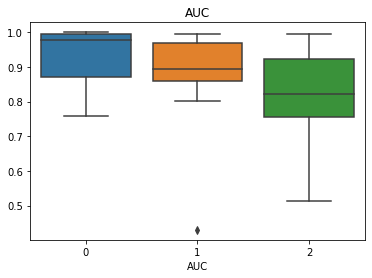

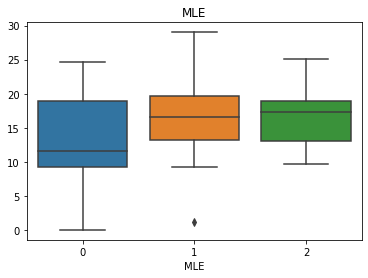

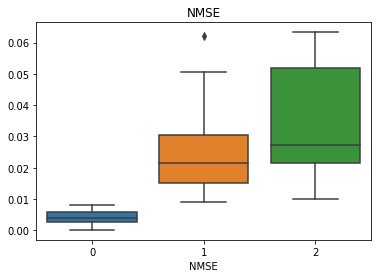

In [45]:
import seaborn as sns
plt.figure()
sns.boxplot(data=np.nanmean(aucs,axis=-1).T)
plt.xlabel("AUC")
plt.title("AUC")

plt.figure()
sns.boxplot(data=np.nanmean(mles,axis=-1).T)
plt.xlabel("MLE")
plt.title("MLE")

plt.figure()
sns.boxplot(data=np.nanmean(nmses,axis=-1).T)
plt.xlabel("NMSE")
plt.title("NMSE")


1


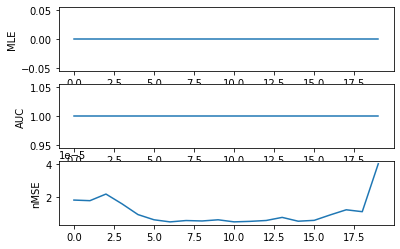

In [36]:
idx = 0

plt.figure()
plt.subplot(311)
plt.plot(mles[0,idx, :])
plt.ylabel("MLE")

plt.subplot(312)
plt.plot(aucs[0,idx, :])
plt.ylabel("AUC")

plt.subplot(313)
plt.plot(nmses[0,idx, :])
plt.ylabel("nMSE")

print(sim_test.simulation_info["number_of_sources"].values[idx])